In [1]:
#%reset -f
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask as da
import glob
import time
from datetime import datetime, timedelta as delta
from matplotlib import path
from matplotlib.collections import PolyCollection #for plots polygons as rasters
#for animation
import matplotlib.animation as animation
from copy import deepcopy
import matplotlib as mpl
import time
#import tqdm 
from tqdm import tqdm #to see progressbar for loops
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find neighbor)
%matplotlib inline
# to see the plot labels when using jupyter-lab dark mode
from matplotlib import style
#style.use('classic') #like matlab style (gray background, but white when saving figures)
#style.use('ggplot')
style.use('default') #the above styles problems with PolyCollection 
#print(style.available) #to see the styles 
import pickle #to save data as binary file .pkl
from windrose import WindroseAxes
import seaborn as sns #for heat maps of correlation and RMSD
from itertools import product #to make all possible permutations including repeated values

#for projections
from pyproj import Proj, transform, Transformer

In [2]:
#
home_dir="/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_wind=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
dir_topo=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
dir_dws_bound=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
#dir_vel=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/velocity/" #vel data
file_topo="DWS200m.2012.v03.nc"
file_dws_bound0="dws_boundaries_contour0.nc"
#file_vel="RE.DWS200m.uvz.20090301.nc" #any vel file
file_wind0="UERRA.2009.nc4" #any wind file
#
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
#
#general dir of interpolated forcing and displacement files
dir_post_proc_data=f"{ml_dir}post_proc_data/" 
dir_interp_wind="wind"

In [3]:
#open interp files for wind
files_interp_wind=sorted(glob.glob(f'{dir_post_proc_data}{dir_interp_wind}/*.nc',recursive=True))
#concat all the files
dswi=xr.open_mfdataset(files_interp_wind,concat_dim="time",parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets

In [4]:
#open topo file
dsto=xr.open_dataset(dir_topo+file_topo) #topo file
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)

#open DWS contours
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0

#open any wind data
dsw=xr.open_dataset(dir_wind+file_wind0) #winds
dsw.close()

#create mask for islands
h=dsto.bathymetry; mask=h.where(np.isnan(h),1); mask=mask.where(np.isfinite(h),0)


#define the transformations------
#1)
#from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
#2)
#from epgs:4326(LatLon with WGS84) to epgs:28992(DWS) 
inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)
#inproj_old=Proj("EPSG:28992") #old method (has errors 10-20m when contrast with the rotated coords)


#lon,lat to 28992(DWS)-projection--------------------

#bathymetry--------
xct=dsto.lonc.values;  yct=dsto.latc.values #lon,lat units
xctp,yctp,z = inproj.transform(xct,yct,xct*0.)
#[xctp,yctp] = inproj_old(xct,yct) #old method
xctp=(xctp)/1e3; yctp=(yctp)/1e3 
#first projected point to correct the coordinates of model local meter units
xctp0=xctp[0,0]; yctp0=yctp[0,0]

#wind original 1h-data--------
#use the full domain---
#usually problems when using local projection for big domains, but for our case no problems
xcw,ycw=np.meshgrid(dsw.lon.values,dsw.lat.values)
xcwp,ycwp,z = inproj.transform(xcw,ycw,xcw*0.)
xcwp=xcwp/1e3; ycwp=ycwp/1e3
#xcw=(xcw-xcw[0,0])/1e3; ycw=(ycw-ycw[0,0])/1e3
#use a short domain around DWS---
xcw2,ycw2=np.meshgrid(dsw.lon.sel(lon=slice(4,6.5)).values,dsw.lat.sel(lat=slice(52.5,53.75)).values)
xcwp2,ycwp2,z = inproj.transform(xcw2,ycw2,xcw2*0.)
xcwp2=(xcwp2)/1e3; ycwp2=(ycwp2)/1e3


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#matrix rotation -17degrees-----
ang=-17*np.pi/180
angs=np.ones((2,2))
angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)

#bathymetry----
#original topo points in meter
xct2,yct2=np.meshgrid(dsto.xc.values,dsto.yc.values)
xy=np.array([xct2.flatten(),yct2.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
xyp0=xyp[0,:] #the first rotated point in the topo data in meter =0,0
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to projection)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dsto.yc.values),len(dsto.xc.values),2))
xctp2=xyp[...,0]; yctp2=xyp[...,1] #km
#
#contrast projections (lon,lat model units to meter) with rotated case
#around 0 meter diff with new method
#10 meter difference in average and maximum of 20 with old method
a=xctp-xctp2; b=yctp-yctp2
print(np.abs(a).max()*1e3, np.abs(b).max()*1e3, np.abs(a).mean()*1e3, np.abs(b).mean()*1e3) 

#contour0 of DWS------
#rotate
bdr_dws0p=np.matmul(angs,bdr_dws0.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to meter)
bdr_dws0p=bdr_dws0p-xyp0 
bdr_dws0p[:,0]=bdr_dws0p[:,0]+xctp0; bdr_dws0p[:,1]=bdr_dws0p[:,1]+yctp0
#
#get coordinates in lon-lat units (WGS84 ) 
bdr_dws0_lon, bdr_dws0_lat, z = proj.transform(bdr_dws0p[:,0]*1e3,bdr_dws0p[:,1]*1e3, bdr_dws0p[:,1]*0.)


#28992(DWS)-projection to local meter model units--------------

#matrix rotation 17degrees-----
ang2=17*np.pi/180
angs2=np.ones((2,2))
angs2[0,0]=np.cos(ang2); angs2[0,1]=np.sin(ang2)
angs2[1,0]=-np.sin(ang2); angs2[1,1]=np.cos(ang2)

#batymetry---
xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
ny,nx=xctp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T
xyl0=xyl[0,:] #the first point 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xctl=xyl[...,0]; yctl=xyl[...,1] #km
#
#errors in the position when using the local values get from transformation (around 0.1% of the grid size)
a=abs(xctl*1e3-dsto.xc.values)
b=abs(yctl.T*1e3-dsto.yc.values)
print('max, mean, max% errors in x (m)',a.max(), a.mean(), a.max()/200*100,"%") # max=12cm, mean=5cm
print('max, mean, max% errors in y (m)',b.max(), b.mean(), b.max()/200*100,"%") # max=32cm, mean=13cm

#original wind---
xy=np.array([xcwp.flatten(),ycwp.flatten()]).T #km
ny,nx=xcwp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point in meter of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xcwl=xyl[...,0]; ycwl=xyl[...,1] #km


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#wind in particle grid------
#the same as the particle grid of displacements (use for convlstm)
xcwi,ycwi=np.meshgrid(dswi.xc.values,dswi.yc.values)
xy=np.array([xcwi.flatten(),ycwi.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
#correct model units:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to meter)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dswi.yc.values),len(dswi.xc.values),2))
xcwip=xyp[...,0]; ycwip=xyp[...,1] #km

#mid point of texel transect---
xymid=np.expand_dims(dsb0.tr_dws_marsdiep[len(dsb0.tr_dws_marsdiep)//2].values,1).T
#find nearest point for wind--------
ixt=np.argmin(abs(dswi.xc.values-xymid[0,0])) 
iyt=np.argmin(abs(dswi.yc.values-xymid[0,1]))
xyt=np.array([[dswi.xc.values[ixt]],[dswi.yc.values[iyt]]]).T
#project
xytp=np.matmul(angs,xyt.T).T/1e3 #rotate
#correct model units
xytp=xytp-xyp0; xytp[:,0]=xytp[:,0]+xctp0; xytp[:,1]=xytp[:,1]+yctp0
#to lon-lat
lont, latt, z = proj.transform(xytp[:,0]*1e3,xytp[:,1]*1e3, xytp[:,1]*0.)

#mid point of vlie-------
xymid=np.expand_dims(dsb0.tr_dws_vlie[len(dsb0.tr_dws_vlie)//2].values,1).T
#find nearest point for wind--------
ixv=np.argmin(abs(dswi.xc.values-xymid[0,0])) 
iyv=np.argmin(abs(dswi.yc.values-xymid[0,1]))
xyv=np.array([[dswi.xc.values[ixv]],[dswi.yc.values[iyv]]]).T
#project
xyvp=np.matmul(angs,xyv.T).T/1e3 #rotate
#correct model units
xyvp=xyvp-xyp0; xyvp[:,0]=xyvp[:,0]+xctp0; xyvp[:,1]=xyvp[:,1]+yctp0
#to lon-lat
lonv, latv, z = proj.transform(xyvp[:,0]*1e3,xyvp[:,1]*1e3, xyvp[:,1]*0.)

#eastern DWS (low mean)-------
#latedw=53.4; lonedw=5.8
#to projection
#xedwp,yedwp,z = inproj.transform(lonedw,latedw,0.)
#xedwp=xedwp/1e3; yedwp=yedwp/1e3
#to model units


#computing wind resolution in km along zonal and meridional directions----------
#using projection obtained from lon-lat--
print()
print("original wind spatial resolution:")
dwpx=np.gradient(xcwp,axis=1); dwpy=np.gradient(ycwp,axis=0)
print(f"along zonal direction: min={dwpx.min():.1f}km ,mean={dwpx.mean():.1f}km ,max={dwpx.max():.1f}km")
print(f"along meridional direction: min={dwpy.min():.1f}km ,mean={dwpy.mean():.1f}km ,max={dwpy.max():.1f}km")
#using lon-lat to get distance from spherical coords--
dwlon=np.diff(dsw.lon.values).mean() #=cte=0.22deg
dwlat=np.diff(dsw.lat.values).mean() #=cte=0.11deg
dwlonx=6371*np.pi/180*dwlon*np.cos(dsw.lat.values.mean()*np.pi/180) #km
dwlaty=6371*np.pi/180*dwlat #km = 111.2*dlat
print(f"Using eq from spherical coords: dlon={dwlon:.1f}deg, dlat={dwlat:.1f}deg, mean(dlon)={dwlonx:.1f}km, dlat={dwlaty:.1f}km") 

0.026940217722426496 0.3400088997977946 0.009365292291273685 0.1443332403121348
max, mean, max% errors in x (m) 0.12412859736627979 0.04687436167418282 0.062064298683139896 %
max, mean, max% errors in y (m) 0.32751821742022 0.13691407317063156 0.16375910871011 %

original wind spatial resolution:
along zonal direction: min=13.4km ,mean=14.4km ,max=15.4km
along meridional direction: min=12.2km ,mean=12.2km ,max=12.3km
Using eq from spherical coords: dlon=0.2deg, dlat=0.1deg, mean(dlon)=14.4km, dlat=12.2km


In [5]:
#rotate wind from local coordinates to projection---
def model_local_coords_to_projection(x,y,ang=-17*np.pi/180):
    return np.cos(ang)*x + np.sin(ang)*y, -np.sin(ang)*x + np.cos(ang)*y

#rotate wind from projection to model coordinates---
def projection_to_model_local_coords(x,y,ang=17*np.pi/180):
    return np.cos(ang)*x + np.sin(ang)*y, -np.sin(ang)*x + np.cos(ang)*y

2009-11-25T15:19:02.000000000


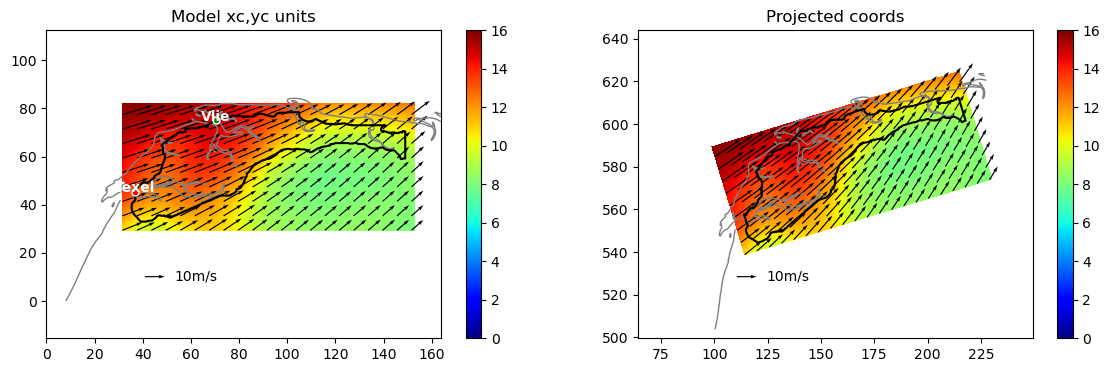

In [106]:
#checking the wind for a particular time---

fig,ax= plt.subplots(1,2,figsize=(14,4))

iyy=15;ixx=15
units='width';width=0.003;scale=200
#it=100
it=np.nonzero(dswi.time.values==np.datetime64("2009-11-25T15:19:02"))[0][0] #SW
#it=np.nonzero(dswi.time.values==np.datetime64("2012-11-24T17:12:46"))[0][0] #SE
#after above SE during the next m2 interval a strong (SW), that only last in total: 2 M2 intervals
#it=np.nonzero(dswi.time.values==np.datetime64("2012-11-24T17:12:46"))[0][0]+3 #strong SW
#velocity in local coords---
u10t=dswi.ws_mean.isel(time=it)*np.cos(dswi.wd_mean.isel(time=it))
v10t=dswi.ws_mean.isel(time=it)*np.sin(dswi.wd_mean.isel(time=it))
vel0=dswi.ws_mean.isel(time=it) #=(u10t**2+v10t**2)**.5
#velocity in projected coords---
#explicity (this is better because keep the xarray structure)
u10tp,v10tp=model_local_coords_to_projection(u10t,v10t)
#
#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[0].pcolormesh(dswi.xc/1e3,dswi.yc/1e3,vel0,vmin=0,vmax=16,shading='auto',cmap='jet') #wind correct orientation
plt.colorbar(aa,ax=ax[0])
ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax[0].plot(dswi.xc.values[ixt]/1e3,dswi.yc.values[iyt]/1e3,'or',markersize=5,markeredgecolor='w') 
ax[0].text(dswi.xc.values[ixt]/1e3,dswi.yc.values[iyt]/1e3,'Texel',color='snow',weight='bold',ha='center') 
ax[0].plot(dswi.xc.values[ixv]/1e3,dswi.yc.values[iyv]/1e3,'og',markersize=5,markeredgecolor='w') 
ax[0].text(dswi.xc.values[ixv]/1e3,dswi.yc.values[iyv]/1e3,'Vlie',color='snow',weight='bold',ha='center') 
Q = ax[0].quiver(xcwi[::iyy,::ixx]/1e3,ycwi[::iyy,::ixx]/1e3,u10t[::iyy,::ixx],v10t[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax[0].quiverkey(Q, .3, .2, 10, '10m/s', labelpos='E',coordinates='axes')
ax[0].axis('equal')#;ax[0].axis([30,150,30,80])
ax[0].set_title('Model xc,yc units');
#
#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[1].pcolormesh(xcwip,ycwip,vel0,vmin=0,vmax=16,shading='auto',cmap='jet') #wind correct orientation
plt.colorbar(aa,ax=ax[1])
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
Q = ax[1].quiver(xcwip[::iyy,::ixx],ycwip[::iyy,::ixx],u10tp[::iyy,::ixx],v10tp[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax[1].quiverkey(Q, .3, .2, 10, '10m/s', labelpos='E',coordinates='axes')
ax[1].axis('equal');#ax[1].axis([30,150,30,80])
#plt.axis([80,250,530,630])
ax[1].set_title('Projected coords');

print(dswi.time.isel(time=it).values)

In [6]:
%%time
#vectorial 36year-mean
u10_mean_vec=(dswi.ws_mean*np.cos(dswi.wd_mean)).mean(dim='time')
v10_mean_vec=(dswi.ws_mean*np.sin(dswi.wd_mean)).mean(dim='time')
wd_mean=np.arctan2(v10_mean_vec,u10_mean_vec)
#scalar
ws_mean=dswi.ws_mean.mean(dim='time')
u10_mean=ws_mean*np.cos(wd_mean); v10_mean=ws_mean*np.sin(wd_mean)
ws_mean_std=dswi.ws_std.mean(dim="time")
wd_mean_std=dswi.wd_std.mean(dim="time")
#compute
u10_mean_vec,v10_mean_vec,u10_mean,v10_mean,ws_mean_std,wd_mean_std=da.compute(u10_mean_vec,v10_mean_vec,u10_mean,v10_mean,ws_mean_std,wd_mean_std)
ws_mean_vec=(u10_mean_vec**2+v10_mean_vec**2)**.5
ws_mean=(u10_mean**2+v10_mean**2)**.5

CPU times: user 44.4 s, sys: 17 s, total: 1min 1s
Wall time: 7.92 s


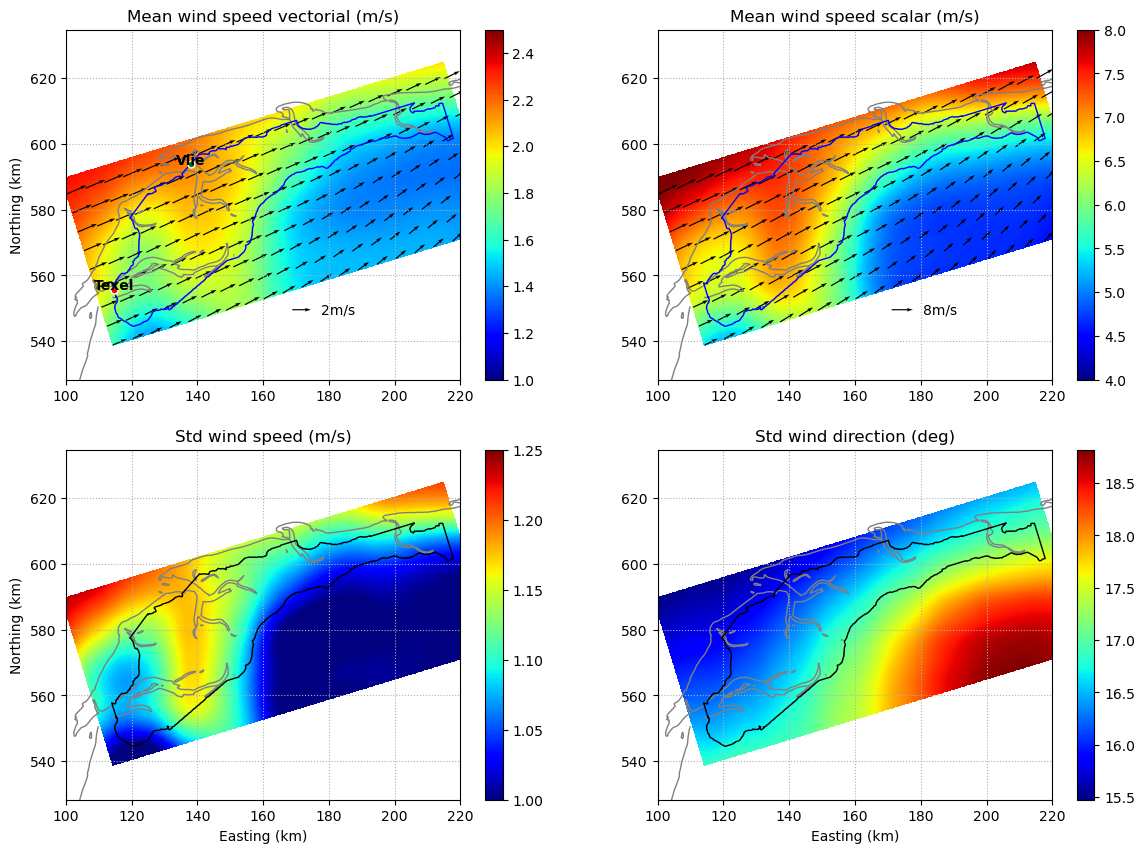

In [50]:
fig,ax= plt.subplots(2,2,figsize=(14,10))
#
aa=ax[0,0].pcolormesh(xcwip,ycwip,ws_mean_vec,vmin=1,vmax=2.5,shading='auto',cmap='jet')#wind-energy lon-lat
ax[0,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'b',lw=1) #DWS limits
ax[0,0].axis('equal');ax[0,0].axis([100,220,543,620]);ax[0,0].grid(ls=":")
#ax[0,0].set_xlabel('Easting (km)')
ax[0,0].set_ylabel('Northing (km)');
ax[0,0].set_title('Mean wind speed vectorial (m/s)');
plt.colorbar(aa,ax=ax[0,0])
#vel_from_local_coords_to_projection
u10_mean_vecp,v10_mean_vecp=model_local_coords_to_projection(u10_mean_vec,v10_mean_vec)
iyy=15;ixx=15
Q = ax[0,0].quiver(xcwip[::iyy,::ixx],ycwip[::iyy,::ixx],u10_mean_vecp[::iyy,::ixx],v10_mean_vecp[::iyy,::ixx],units='width',width=0.003,color='k')
qk = ax[0,0].quiverkey(Q, 0.3, 0.6, 2, '2m/s', labelpos='E',coordinates='figure')
#stations
ax[0,0].plot(xytp[0,0],xytp[0,1],'or',markersize=5,markeredgecolor='w') 
ax[0,0].text(xytp[0,0],xytp[0,1],'Texel',color='k',weight='bold',ha='center') 
ax[0,0].plot(xyvp[0,0],xyvp[0,1],'og',markersize=5,markeredgecolor='w') 
ax[0,0].text(xyvp[0,0],xyvp[0,1],'Vlie',color='k',weight='bold',ha='center') 
#ax[0,0].plot(xedwp[0,0],yedwp[0,1],'or',markersize=5,markeredgecolor='w') 
#ax[0,0].text(xedwp[0,0],yedwp[0,1],'EDWS',color='snow',weight='bold',ha='center') 
#
aa=ax[0,1].pcolormesh(xcwip,ycwip,ws_mean,vmin=4,vmax=8,shading='auto',cmap='jet')#wind-energy lon-lat
ax[0,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'b',lw=1) #DWS limits
ax[0,1].axis('equal');ax[0,1].axis([100,220,543,620]);ax[0,1].grid(ls=":")
#ax[0,1].set_xlabel('Easting (km)');ax[0,1].set_ylabel('Northing (km)');
ax[0,1].set_title('Mean wind speed scalar (m/s)');
plt.colorbar(aa,ax=ax[0,1])
#vel_from_local_coords_to_projection
u10_meanp,v10_meanp=model_local_coords_to_projection(u10_mean,v10_mean)
Q = ax[0,1].quiver(xcwip[::iyy,::ixx],ycwip[::iyy,::ixx],u10_meanp[::iyy,::ixx],v10_meanp[::iyy,::ixx],units='width',width=0.003,color='k')
qk = ax[0,1].quiverkey(Q, 0.73, 0.6, 8, '8m/s', labelpos='E',coordinates='figure')
#
aa=ax[1,0].pcolormesh(xcwip,ycwip,ws_mean_std,vmin=1,vmax=1.25,shading='auto',cmap='jet')#wind-energy lon-lat
ax[1,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k',lw=1) #DWS limits
ax[1,0].axis('equal');ax[1,0].axis([100,220,543,620]);ax[1,0].grid(ls=":")
ax[1,0].set_xlabel('Easting (km)');ax[1,0].set_ylabel('Northing (km)');
ax[1,0].set_title('Std wind speed (m/s)');
plt.colorbar(aa,ax=ax[1,0])
#
aa=ax[1,1].pcolormesh(xcwip,ycwip,wd_mean_std*180/np.pi,shading='auto',cmap='jet')#wind-energy lon-lat
ax[1,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k',lw=1) #DWS limits
ax[1,1].axis('equal');ax[1,1].axis([100,220,543,620]);ax[1,1].grid(ls=":")
ax[1,1].set_xlabel('Easting (km)')
ax[1,1].set_title('Std wind direction (deg)');
plt.colorbar(aa,ax=ax[1,1]);

In [51]:
def get_autocorr(ws_xr,tw):
    
    dtw=np.diff(tw) / np.timedelta64(1,'s')
    dtw=dtw[0]/3600 #=1h
    #
    #num time steps for the month with less data (February)
    #we will set the length of the lag correlation of all the months to this value
    ntcor=int(24/dtw*28) 
    #
    #compute lag correlation for each month
    
    #first group the years, then the months
    autocorr=[]
    for label0, x0 in ws_xr.groupby('time.year'):
        for label1, x1 in x0.groupby('time.month'):
            #print(label1)
            val=np.correlate(x1-x1.mean(),x1-x1.mean(),mode='full')[-len(x1.time):] #pad with zeros when lag time series
            val/=val[0] #normalized autocorrelation
            autocorr.append(val[:ntcor])
    autocorr=np.array(autocorr).T #(lag,months)
    tlag=np.arange(0,autocorr.shape[0]*dtw,dtw)/24 #days
    #months=np.arange(1,13)

    #np.correlate does below:
    # avg=x.mean().values; var=np.sum((x.values-avg)**2)
    # val=x-avg; val=val.values
    # cor=[]
    # for lag in range(autocorr.shape[1]):
    #     if lag==0: cor.append(1)
    #     else: cor.append(np.sum(val[:-lag]*val[lag:])/var)
    # cor=np.array(cor)
    # #both are the same
    # plt.plot(tlag,cor,'b')
    # plt.plot(tlag,autocorr[-1,:],'r')
    
    return tlag,autocorr

In [52]:
tw=dswi.time.values

In [57]:
#texel---
ws_mean_scalar_tex=dswi.ws_mean.isel(xc=ixt,yc=iyt).load()
tlag,autocorr_tex=get_autocorr(ws_mean_scalar_tex,tw) 
yearini="1980"; yearend="2016"
tcorr_tex=np.arange(yearini,yearend,1,dtype='datetime64[M]')[:-2] #skip nov and dec of 2015

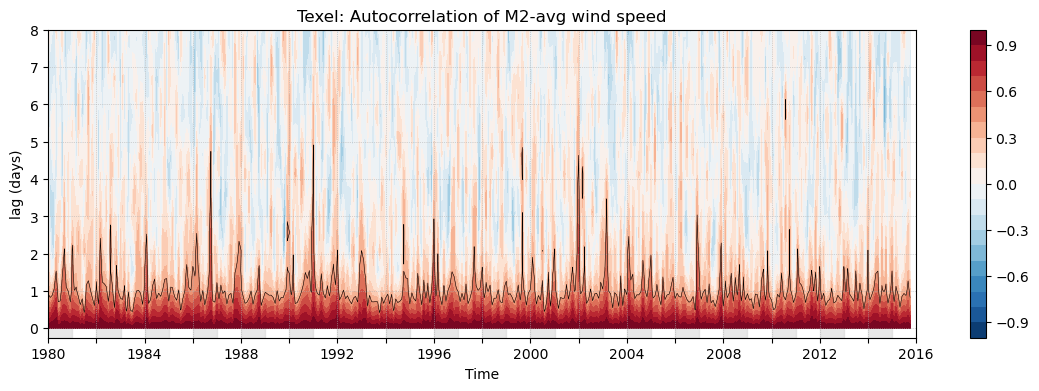

In [58]:
fig,ax=plt.subplots(1,1,figsize=(14,4))
#
#ticks for time 
xticks_lab=np.arange(int(str(tw[0])[:4]),int(str(tw[-1])[:4])+2,2)
xticks=[np.datetime64(str(i)+'-01-01') for i in xticks_lab]
tt=np.arange(np.datetime64("1980"),np.datetime64("2018"),2)
tt2=np.arange(np.datetime64("1981"),np.datetime64("2017"),2)
for i in range(len(tt)-1): ax.axvspan(tt[i],tt2[i],alpha=0.5,color='lightgrey',zorder=0) 
ax.set_xlim([xticks[0],xticks[-1]])
ax.set_xticks(xticks); ax.set_xticklabels(xticks_lab);
for label in ax.get_xticklabels()[1::2]: label.set_visible(False) #hide every 2 tick label
ax.tick_params(direction="out");
#
#time_ticklabels=['J','F','M','A','M','J','J','A','S','O','N','D']
cb=ax.contourf(tcorr_tex,tlag,autocorr_tex,levels=np.arange(-1,1.1,.1),cmap='RdBu_r',zorder=1);plt.colorbar(cb,ax=ax)
ax.contour(tcorr_tex,tlag,autocorr_tex,[.4],colors='k',linestyles='-',linewidths=.4)
ax.set_ylim(-.25,8);ax.set_ylabel('lag (days)');ax.set_xlabel("Time");ax.set_title(f"Texel: Autocorrelation of M2-avg wind speed");
ax.grid(lw=.5,ls=':')
#

In [59]:
#vlie---
ws_mean_scalar_vlie=dswi.ws_mean.isel(xc=ixv,yc=iyv).load()
tlag,autocorr_vlie=get_autocorr(ws_mean_scalar_vlie,tw) 
yearini="1980"; yearend="2016"
tcorr_vlie=np.arange(yearini,yearend,1,dtype='datetime64[M]')[:-2] #skip nov and dec of 2015

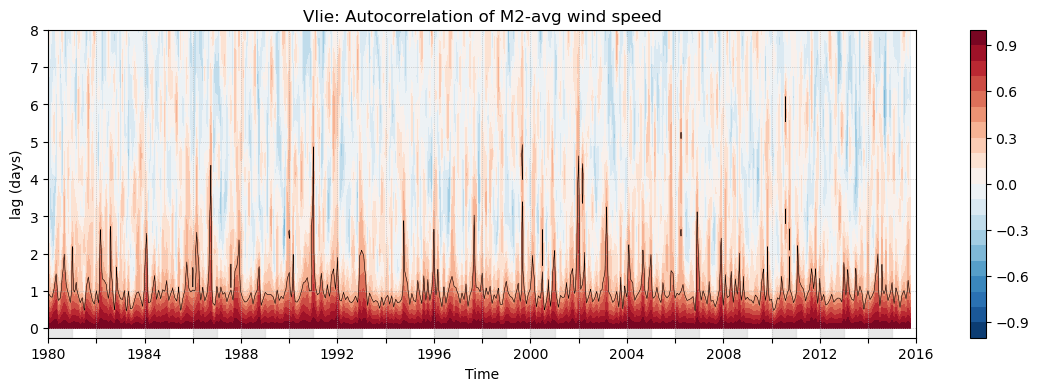

In [60]:
fig,ax=plt.subplots(1,1,figsize=(14,4))
#
#ticks for time 
xticks_lab=np.arange(int(str(tw[0])[:4]),int(str(tw[-1])[:4])+2,2)
xticks=[np.datetime64(str(i)+'-01-01') for i in xticks_lab]
tt=np.arange(np.datetime64("1980"),np.datetime64("2018"),2)
tt2=np.arange(np.datetime64("1981"),np.datetime64("2017"),2)
for i in range(len(tt)-1): ax.axvspan(tt[i],tt2[i],alpha=0.5,color='lightgrey',zorder=0) 
ax.set_xlim([xticks[0],xticks[-1]])
ax.set_xticks(xticks); ax.set_xticklabels(xticks_lab);
for label in ax.get_xticklabels()[1::2]: label.set_visible(False) #hide every 2 tick label
ax.tick_params(direction="out");
#
#time_ticklabels=['J','F','M','A','M','J','J','A','S','O','N','D']
cb=ax.contourf(tcorr_vlie,tlag,autocorr_vlie,levels=np.arange(-1,1.1,.1),cmap='RdBu_r',zorder=1);plt.colorbar(cb,ax=ax)
ax.contour(tcorr_vlie,tlag,autocorr_vlie,[.4],colors='k',linestyles='-',linewidths=.4)
ax.set_ylim(-.25,8);ax.set_ylabel('lag (days)');ax.set_xlabel("Time");ax.set_title(f"Vlie: Autocorrelation of M2-avg wind speed");
ax.grid(lw=.5,ls=':')
#

### Check histograms

In [7]:
%%time
ws,wd,ws_std,wd_std=da.compute(dswi.ws_mean,dswi.wd_mean,dswi.ws_std,dswi.wd_std)

CPU times: user 3.82 s, sys: 10.9 s, total: 14.8 s
Wall time: 14.7 s


CPU times: user 2min 53s, sys: 20.7 s, total: 3min 13s
Wall time: 3min 1s


Text(0.5, 0, '(deg)')

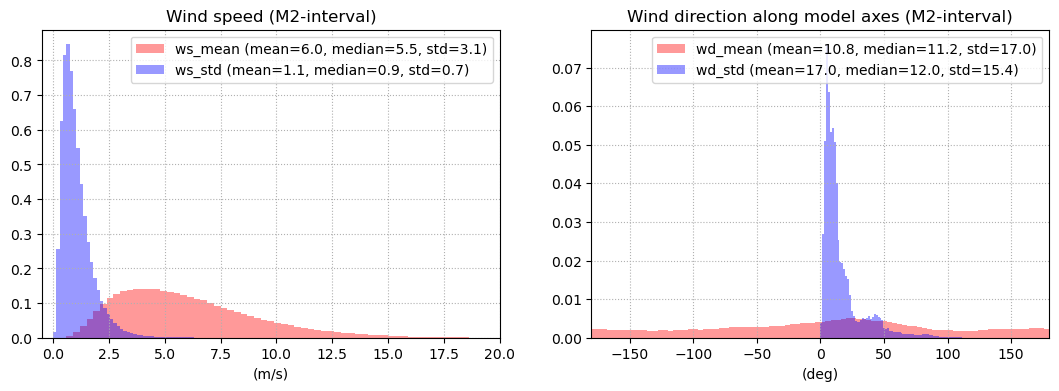

In [160]:
%%time
fig,ax=plt.subplots(1,2,figsize=(13,4))
#
ax[0].hist(ws.values.flatten(), bins=np.arange(0,24,0.3), alpha=0.4, density=True, color='red', label=f'ws_mean (mean={np.mean(ws.values):.1f}, median={np.median(ws.values):.1f}, std={np.std(ws.values):.1f})');
ax[0].hist(ws_std.values.flatten(), bins=np.arange(0,12,0.15), alpha=0.4, density=True, color='blue', label=f'ws_std (mean={np.mean(ws_std.values):.1f}, median={np.median(ws_std.values):.1f}, std={np.std(ws_std.values):.1f})');
ax[0].set_xlim(-.5,20);ax[0].legend(); ax[0].grid(ls=":");
ax[0].set_title("Wind speed (M2-interval)");ax[0].set_xlabel("(m/s)");
#
ax[1].hist((wd*180/np.pi).values.flatten(), bins=np.arange(-180,184,4), alpha=0.4, density=True, color='red', label=f'wd_mean (mean={np.mean(wd_mean.values)*180/np.pi:.1f}, median={np.median(wd.values)*180/np.pi:.1f}, std={np.mean(wd_mean_std.values)*180/np.pi:.1f})');
ax[1].hist((wd_std[:100,...]*180/np.pi).values.flatten(), bins=np.arange(0,131.5,1.5), alpha=0.4, density=True, color='blue', label=f'wd_std (mean={np.mean(wd_std.values)*180/np.pi:.1f}, median={np.median(wd_std.values)*180/np.pi:.1f}, std={np.std(wd_std.values)*180/np.pi:.1f})');
ax[1].set_xlim(-180,180);ax[1].legend(); ax[1].grid(ls=":");
ax[1].set_title("Wind direction along model axes (M2-interval)");ax[1].set_xlabel("(deg)");

In [9]:
#wind direction with respect to zonal axis----
#
wd_vals_lon0=np.arange(-180,180+1,45) #directions with respect to zonal direction
#wd_vals_xc0=wd_vals_lon0-17 #with respect to loca model x-axis, however have to modify when beyond -/+180
wd_labs=["E","NE","N","NW","W","SW","S","SE","E"]
#
wd2=wd*180/np.pi+17
wd2=xr.where(wd2>180,wd2-360,wd2)

CPU times: user 3min 40s, sys: 17.9 s, total: 3min 58s
Wall time: 3min 46s


Text(0.5, 1.0, 'Wind direction (M2-interval)')

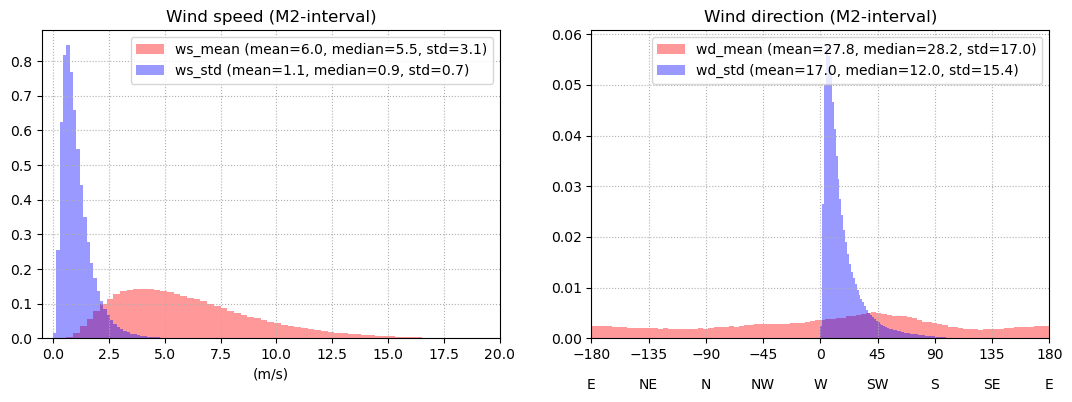

In [161]:
%%time
fig,ax=plt.subplots(1,2,figsize=(13,4))
#
ax[0].hist(ws.values.flatten(), bins=np.arange(0,24,0.3), alpha=0.4, density=True, color='red', label=f'ws_mean (mean={np.mean(ws.values):.1f}, median={np.median(ws.values):.1f}, std={np.std(ws.values):.1f})');
ax[0].hist(ws_std.values.flatten(), bins=np.arange(0,12,0.15), alpha=0.4, density=True, color='blue', label=f'ws_std (mean={np.mean(ws_std.values):.1f}, median={np.median(ws_std.values):.1f}, std={np.std(ws_std.values):.1f})');
ax[0].set_xlim(-.5,20);ax[0].legend(); ax[0].grid(ls=":");
ax[0].set_title("Wind speed (M2-interval)");ax[0].set_xlabel("(m/s)");
#
ax[1].hist(wd2.values.flatten(), bins=np.arange(-180,184,4), alpha=0.4, density=True, color='red', label=f'wd_mean (mean={np.mean(wd_mean.values)*180/np.pi+17:.1f}, median={np.median(wd.values)*180/np.pi+17:.1f}, std={np.mean(wd_mean_std.values)*180/np.pi:.1f})');
ax[1].hist((wd_std*180/np.pi).values.flatten(), bins=np.arange(0,131.5,1.5), alpha=0.4, density=True, color='blue', label=f'wd_std (mean={np.mean(wd_std.values)*180/np.pi:.1f}, median={np.median(wd_std.values)*180/np.pi:.1f}, std={np.std(wd_std.values)*180/np.pi:.1f})');
ax[1].set_xlim(-180,180);ax[1].set_xticks(range(-180,180+45,45));
ax[1].legend(); ax[1].grid(ls=":");
for i,val in enumerate(wd_vals_lon0): ax[1].text(val,-.01,wd_labs[i],ha="center");
ax[1].set_title("Wind direction (M2-interval)");

In [10]:
ws_val=ws.values.flatten()

No handles with labels found to put in legend.


CPU times: user 48.9 s, sys: 1.56 s, total: 50.4 s
Wall time: 50.5 s


Text(0.5, 0, 'standarized')

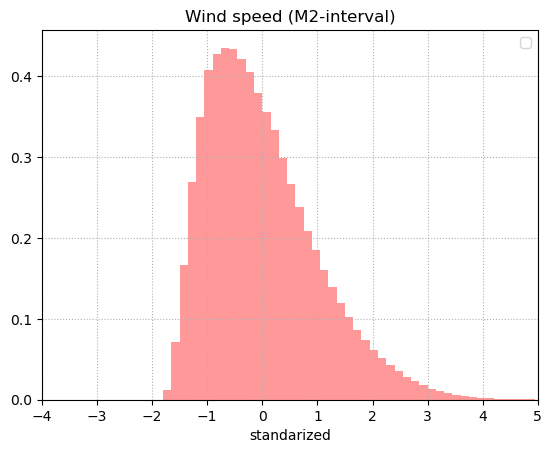

In [202]:
%%time
plt.hist((ws_val-np.mean(ws_val))/np.std(ws_val), bins=np.arange(-6,6.15,0.15), alpha=0.4, density=True, color='red');
plt.xlim(-4,5);plt.legend(); plt.grid(ls=":");
plt.title("Wind speed (M2-interval)");plt.xlabel("standarized");

No handles with labels found to put in legend.


CPU times: user 48.9 s, sys: 1.58 s, total: 50.4 s
Wall time: 50.5 s


Text(0.5, 0, 'standarized (3std)')

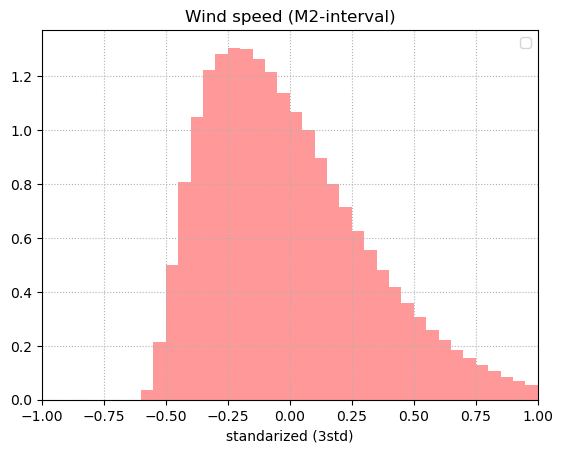

In [191]:
%%time
plt.hist((ws_val-np.mean(ws_val))/(3*np.std(ws_val)), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red');
plt.xlim(-1,1);plt.legend(); plt.grid(ls=":");
plt.title("Wind speed (M2-interval)");plt.xlabel("standarized (3std)");

In [16]:
ws_std_val=ws_std.values.flatten()

In [20]:
#using min-max-scalar
ws_sc=(ws_val-np.min(ws_val))/(np.max(ws_val)-np.min(ws_val));  #[0,1]
ws_std_sc=(ws_std_val-np.min(ws_std_val))/(np.max(ws_std_val)-np.min(ws_std_val)) #[0,1]
#ws_std_sc2=2.*ws_std_sc-1 #[-1,1], give mean distribution close to -1 far away from ws distribution (not ok)
#
#also try to use the same min and max of the training for the validation and testing data
#because for production we don't know the targets, so it is better this approach
#
#So:
#- use min-max scalar with positive quantities
#- it preserves shape, we dont have to worry about the factor to multiply the std
#- it gives positive values, which is consistent with a magnitude

CPU times: user 1min 36s, sys: 2.18 s, total: 1min 39s
Wall time: 1min 39s


Text(0.5, 0, 'min-max normalization')

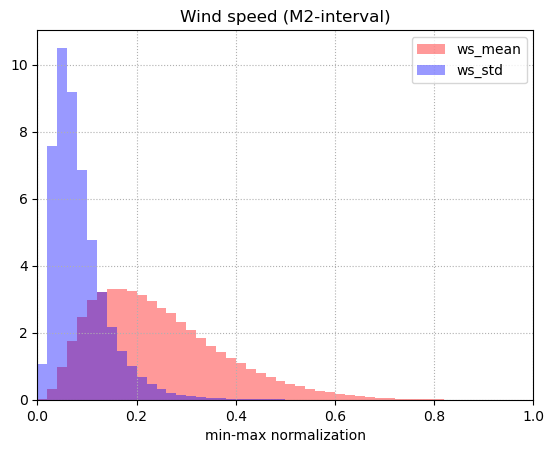

In [19]:
%%time
plt.hist(ws_sc, bins=np.arange(0,1.02,0.02), alpha=0.4, density=True, color='red',label="ws_mean");
plt.hist(ws_std_sc, bins=np.arange(0,1.02,0.02), alpha=0.4, density=True, color='blue',label="ws_std");
plt.xlim(0,1); plt.legend(); plt.grid(ls=":")
plt.title("Wind speed (M2-interval)");plt.xlabel("min-max normalization");